# 7th Project - Predict Future Sales

<img src="https://alchemiseconsulting.com/wp-content/uploads/2017/09/Financial-paper-charts-and-graphs-on-the-table.jpeg" width="700px">

### Author: Arthur Dimitri 
### E-mail: arthur.dimitri@ee.ufcg.edu.br

# Table of Contents

* ### [1. Introduction](#section-one)
* ### [2. Dataset Description](#section-two)
* ### [3. Dependencies](#section-three)
* ### [4. Loading The Data](#section-four)
* ### [5. Basic Feature Engineering](#section-five)
* ### [6. Exploratory Data Analysis](#section-six)
* ### [7. Data Cleaning](#section-seven)
* ### [8. Feature Engineering](#section-eight)
* ### [9. Model Training](#section-nine)
* ### [10. Results](#section-ten)
* ### [11. Submission](#section-eleven)
* ### [12. Conclusion](#section-twelve)

<a id="section-one"></a>
# 1. Introduction

Although the sales market has a seasonal behavior, the number of sales for each shop, product and category might vary stochastically. Given previous data, how to forecast the sales? What if some shops have missing data? This is the challenge here: predict future sales for each shop and product for November 2015. 


<a id="section-two"></a>
# 2. Dataset Description

## File descriptions
* **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
* **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
* **sample_submission.csv** - a sample submission file in the correct format.
* **items.csv** - supplemental information about the items/products.
* **item_categories.csv**  - supplemental information about the items categories.
* **shops.csv** - supplemental information about the shops.

## Features
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv


<a id="section-three"></a>
# 3. Dependencies

In [2]:
pip install googletrans

     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 42 kB 759 kB/s 
     |████████████████████████████████| 908 kB 17.9 MB/s 
     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 53 kB 1.3 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15734 sha256=04022460d4462d792d49b3721e4bb759a477443b913d57bc2c8ee4226fc8e717
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from xgboost import plot_importance

<a id="section-four"></a>
# 4. Loading the Data

In [4]:
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
categories = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

To ease our job, we could concatenate the datasets:

In [5]:
train = pd.merge(train,items,on='item_id',how='inner')
train = pd.merge(train,shops,on='shop_id',how='inner')
train = pd.merge(train,categories, on='item_category_id',how='inner')


test = pd.merge(test,items,on='item_id',how='inner')
test = pd.merge(test,shops,on='shop_id',how='inner')
test = pd.merge(test,categories, on='item_category_id',how='inner')

test.head()

,ID,shop_id,item_id,item_name,item_category_id,shop_name,item_category_name
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,"Вологда ТРЦ ""Мармелад""",Игры - PS3
1,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,"Вологда ТРЦ ""Мармелад""",Игры - PS3
2,15,5,4872,"Minecraft. Playstation 3 Edition [PS3, русская...",19,"Вологда ТРЦ ""Мармелад""",Игры - PS3
3,21,5,5002,"NBA 2K16 [PS3, русская документация]",19,"Вологда ТРЦ ""Мармелад""",Игры - PS3
4,23,5,5814,"Plants vs. Zombies Garden Warfare [PS3, русска...",19,"Вологда ТРЦ ""Мармелад""",Игры - PS3


In [6]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
2,26.06.2013,5,59,944,199.5,1.0,2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
3,20.07.2013,6,59,944,199.5,1.0,2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
4,14.09.2013,8,59,944,299.0,2.0,2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
...,...,...,...,...,...,...,...,...,...,...
2935844,22.10.2015,33,55,13093,250.0,1.0,Карта оплаты Windows: 250 рублей [Цифровая вер...,36,Цифровой склад 1С-Онлайн,Карты оплаты - Windows (Цифра)
2935845,21.09.2015,32,55,13091,1000.0,1.0,Карта оплаты Windows: 1000 рублей [Цифровая ве...,36,Цифровой склад 1С-Онлайн,Карты оплаты - Windows (Цифра)
2935846,16.09.2015,32,55,13094,2500.0,1.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Цифровой склад 1С-Онлайн,Карты оплаты - Windows (Цифра)
2935847,22.09.2015,32,55,13094,2500.0,2.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Цифровой склад 1С-Онлайн,Карты оплаты - Windows (Цифра)


In [7]:
from googletrans import Translator

def translateRussian(row):
    translator = Translator()  
    return translator.translate(row).text

#train_df['item_name'] = train_df.item_name.apply(lambda row: translateRussian(train_df.item_name))
#train_df

<a id="section-five"></a>
# 5. Basic Feature Engineering

We format the 'date' column to ease the EDA. Also we add some date related features to explore some periods of time.

In [8]:
train.date = pd.to_datetime(train.date,format="%d.%m.%Y")
train = train.assign(month = train.date.dt.month, year = train.date.dt.year, weekday = train.date.dt.weekday)

<a id="section-six"></a>
# 6. Exploratory Data Analysis

Before we dive into the series analysis, we need to familiarize with the data and retrieve some insights. Some questions could guide our examination:
* Are there any missing values? How could we fill them?
* Are there seasonalities? (hour, day, month, year)
* Which stores sell the most?
* Which are the best-selling products?
* How is the distribution of units sold and average price?
* Which cities have the most significant stores?

In [9]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,month,year,weekday
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01,6.247717e+00,2.013777e+03,3.365686e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01,3.536219e+00,7.684790e-01,1.996795e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00,1.000000e+00,2.013000e+03,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01,3.000000e+00,2.013000e+03,2.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01,6.000000e+00,2.014000e+03,4.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01,9.000000e+00,2.014000e+03,5.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01,1.200000e+01,2.015000e+03,6.000000e+00


### Missing Values

In [10]:
for feature in train.columns.tolist():
    print("In the", feature, "column there are ", train[feature].isnull().sum() ,"null values")

In the date column there are  0 null values
In the date_block_num column there are  0 null values
In the shop_id column there are  0 null values
In the item_id column there are  0 null values
In the item_price column there are  0 null values
In the item_cnt_day column there are  0 null values
In the item_name column there are  0 null values
In the item_category_id column there are  0 null values
In the shop_name column there are  0 null values
In the item_category_name column there are  0 null values
In the month column there are  0 null values
In the year column there are  0 null values
In the weekday column there are  0 null values


As we can see, there aren't any missing feature values. It doesn't mean that there aren't missing records, which we should deal with later. 

### Sales by Periods

### By Day

In [11]:
train_resampled_month = train[["date", "item_cnt_day"]].set_index("date").resample("M").sum()
train_resampled_weekly = train[["date", "item_cnt_day"]].set_index("date").resample("W").sum()
train_resampled_month = train_resampled_month.rename(columns={"item_cnt_day":"month_cnt"})
train_resampled_day = train.groupby('date').item_cnt_day.sum()

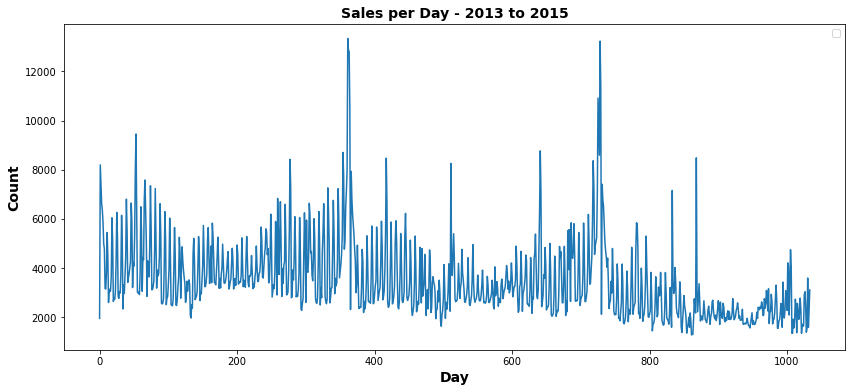

In [12]:
plt.figure(figsize=(14,6))
plt.title('Sales per Day - 2013 to 2015',fontsize=14,fontweight='bold')
plt.xlabel('Day',fontsize=14,fontweight='bold')
plt.ylabel('Count',fontsize=14,fontweight='bold')
plt.plot(train_resampled_day.values)
plt.legend()
plt.show()

We can notice that there are some spikes that have a seasonal behavior. We are going to analyze them next.

### Decomposition (multiplicative) - Daily

Text(0, 0.5, 'Residual')

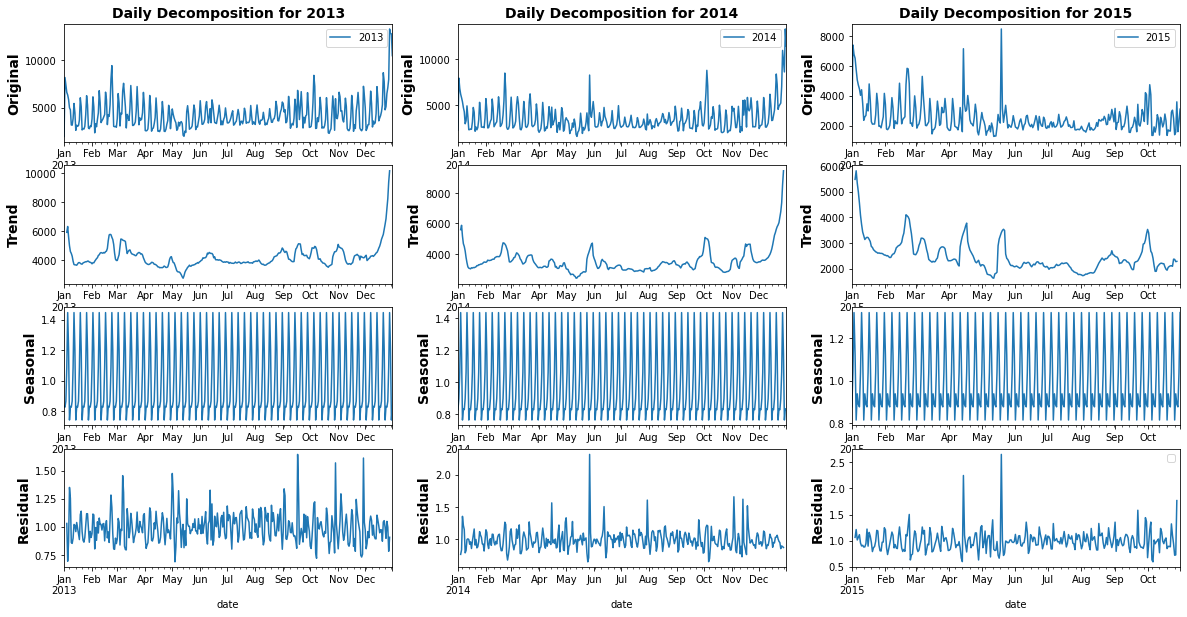

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train[train.year == 2013].groupby('date').item_cnt_day.sum(), model='multiplicative')
result2 = seasonal_decompose(train[train.year == 2014].groupby('date').item_cnt_day.sum(), model='multiplicative')
result3 = seasonal_decompose(train[train.year == 2015].groupby('date').item_cnt_day.sum(), model='multiplicative')
fig, axes = plt.subplots(ncols = 3, nrows = 4, sharex = False, figsize = (20,10))
result.observed.plot(ax = axes[0][0], legend = True, label='2013')

plt.legend()
axes[0][0].set_title('Daily Decomposition for 2013',fontsize=14,fontweight='bold')
axes[0][0].set_ylabel('Original',fontsize=14,fontweight='bold')

result.trend.plot(ax = axes[1][0], legend = False)
axes[1][0].set_ylabel('Trend',fontsize=14,fontweight='bold')

result.seasonal.plot(ax = axes[2][0], legend = False)
axes[2][0].set_ylabel('Seasonal',fontsize=14,fontweight='bold')

result.resid.plot(ax = axes[3][0], legend = False)
axes[3][0].set_ylabel('Residual',fontsize=14,fontweight='bold')

################################################################## 

result2.observed.plot(ax = axes[0][1], legend = True, label='2014')
axes[0][1].set_title('Daily Decomposition for 2014',fontsize=14,fontweight='bold')
axes[0][1].set_ylabel('Original',fontsize=14,fontweight='bold')

result2.trend.plot(ax = axes[1][1], legend = False)
axes[1][1].set_ylabel('Trend',fontsize=14,fontweight='bold')

result2.seasonal.plot(ax = axes[2][1], legend = False)
axes[2][1].set_ylabel('Seasonal',fontsize=14,fontweight='bold')

result2.resid.plot(ax = axes[3][1], legend = False)
axes[3][1].set_ylabel('Residual',fontsize=14,fontweight='bold')


################################################################## 

result3.observed.plot(ax = axes[0][2], legend = True, label='2015')
axes[0][2].set_title('Daily Decomposition for 2015',fontsize=14,fontweight='bold')
axes[0][2].set_ylabel('Original',fontsize=14,fontweight='bold')

result3.trend.plot(ax = axes[1][2], legend = False)
axes[1][2].set_ylabel('Trend',fontsize=14,fontweight='bold')

result3.seasonal.plot(ax = axes[2][2], legend = False)
axes[2][2].set_ylabel('Seasonal',fontsize=14,fontweight='bold')

result3.resid.plot(ax = axes[3][2], legend = False)
axes[3][2].set_ylabel('Residual',fontsize=14,fontweight='bold')



From these plots we can see that there are some trends, but our data is stationary. For all the years we notice some peaks at the end of February. Also a peak from the second half of May to June. Since we only have records until October for 2015, we only see a significant increase on the sales on December for 2013 and 2014. In 2014 and 2015, we see a significant increase on the number of item sales. 

### By month

### Monthly Decomposition

Text(0, 0.5, 'Residual')

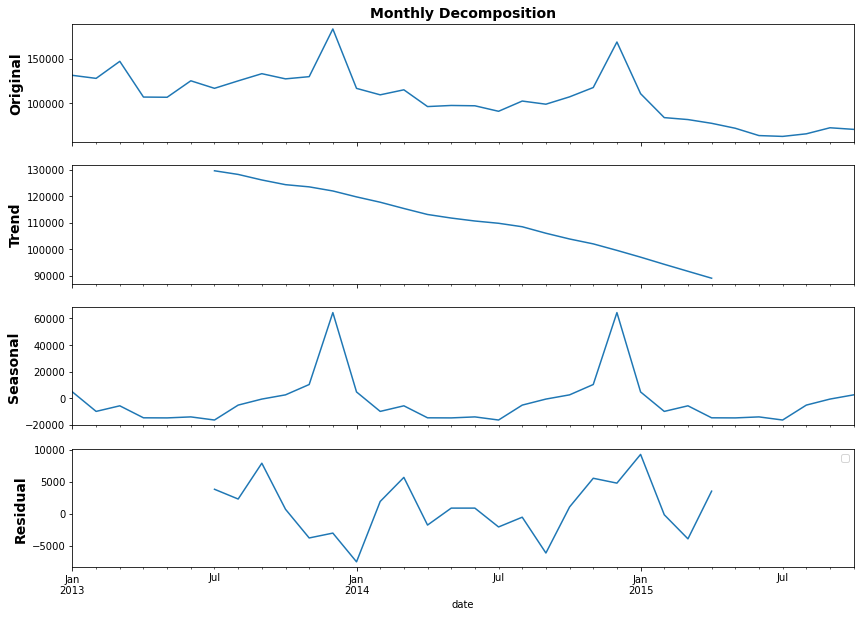

In [14]:
train_monthly = train.set_index("date").resample("M")["item_cnt_day"].sum().to_frame()
result = seasonal_decompose(train_monthly["item_cnt_day"])

fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize = (14,10))
result.observed.plot(ax = axes[0], legend = False)

plt.legend()
axes[0].set_title('Monthly Decomposition',fontsize=14,fontweight='bold')
axes[0].set_ylabel('Original',fontsize=14,fontweight='bold')

result.trend.plot(ax = axes[1], legend = False)
axes[1].set_ylabel('Trend',fontsize=14,fontweight='bold')

result.seasonal.plot(ax = axes[2], legend = False)
axes[2].set_ylabel('Seasonal',fontsize=14,fontweight='bold')

result.resid.plot(ax = axes[3], legend = False)
axes[3].set_ylabel('Residual',fontsize=14,fontweight='bold')

As one can see, there are some spikes. These are seasonalities probably related to the increase of demand for christmas celebrations.

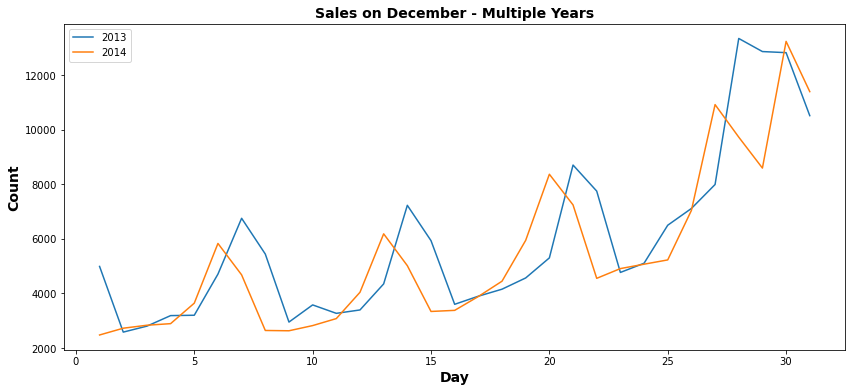

In [15]:
plt.figure(figsize=(14,6))
plt.title('Sales on December - Multiple Years',fontsize=14,fontweight='bold')
plt.xlabel('Day',fontsize=14,fontweight='bold')
plt.ylabel('Count',fontsize=14,fontweight='bold')
plt.plot(range(1,32),train.loc[(train.month == 12) & (train.year == 2013)].groupby('date').item_cnt_day.sum().values, label='2013')
plt.plot(range(1,32),train.loc[(train.month == 12) & (train.year == 2014)].groupby('date').item_cnt_day.sum().values, label='2014')
plt.legend()

As can be seen above, there are some spikes during the month. The demand starts increasing from 25th day and, surprisingly, reaches its peak at the end of the month.

### Distribution Plots

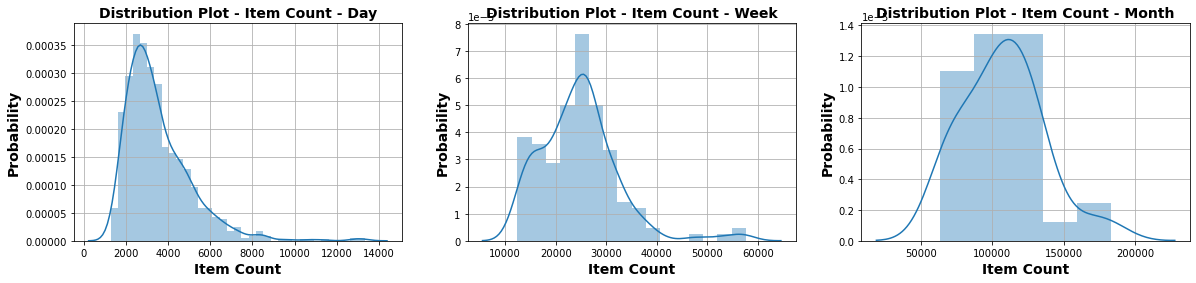

In [16]:
fig, axes = plt.subplots(ncols = 3, nrows = 1, sharex = False, figsize = (20,4))
axes[0].set_title('Distribution Plot - Item Count - Day', fontsize=14, weight='bold')
axes[0].set_xlabel('Item Count', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Probability', fontsize=14, fontweight='bold')
axes[0].grid()
sns.distplot(train.groupby('date').item_cnt_day.sum().values.tolist(),ax=axes[0])

axes[1].set_title('Distribution Plot - Item Count - Week', fontsize=14, weight='bold')
axes[1].set_xlabel('Item Count', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Probability', fontsize=14, fontweight='bold')
axes[1].grid()
sns.distplot(train_resampled_weekly,ax=axes[1])

axes[2].set_title('Distribution Plot - Item Count - Month', fontsize=14, weight='bold')
axes[2].set_xlabel('Item Count', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Probability', fontsize=14, fontweight='bold')
axes[2].grid()
sns.distplot(train_monthly,ax=axes[2])

These plots give some insights about the most probable values in each period of observation for all stores. For each day and week, the item count will be probably around 2k~4k and 20k~40k items, respectively, whilst during the whole month, it will be probably close to 100k items. 

### **Best-Selling Shops**

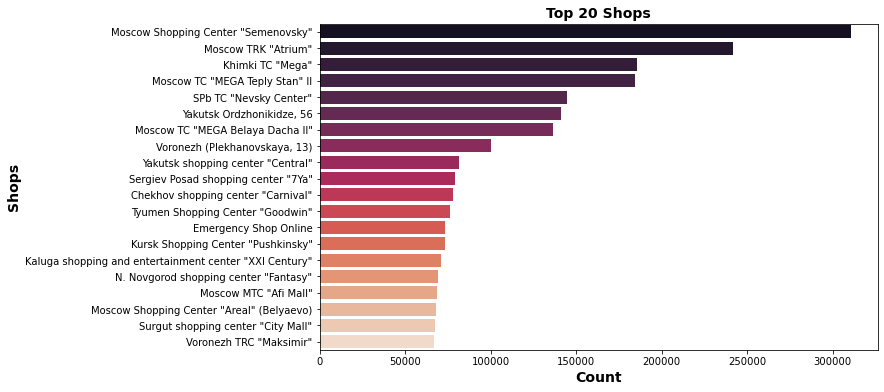

In [17]:
shops_df = train.groupby('shop_name').item_cnt_day.sum()
shops_df = pd.DataFrame({'shop':shops_df.index.tolist(),'count':shops_df.values.tolist()})
shops_df = shops_df.sort_values(by='count',ascending=False).reset_index()
shops_df_translate = shops_df.copy()
shops_df_translate['shop'] = shops_df.shop.apply(lambda row: translateRussian(row))


plt.figure(figsize=(10,6))
plt.title('Top 20 Shops', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Shops', fontsize=14, fontweight='bold')
sns.barplot(shops_df['count'].tolist()[0:20],shops_df_translate.shop.tolist()[0:20], palette='rocket')
plt.show()

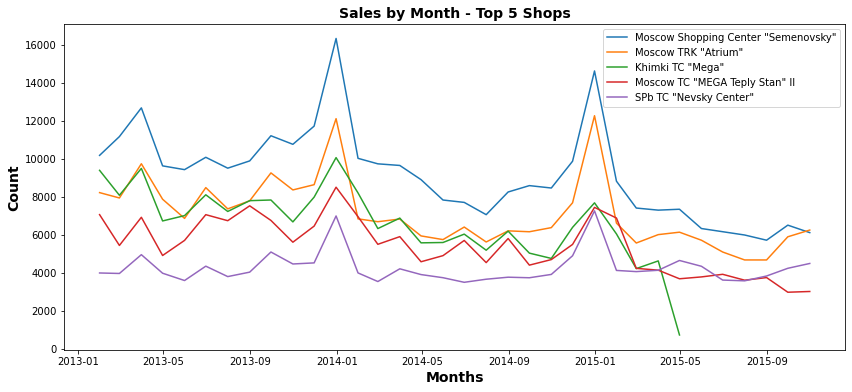

In [18]:
plt.figure(figsize=(14,6))
plt.title('Sales by Month - Top 5 Shops',fontsize=14,fontweight='bold')
plt.xlabel('Months',fontsize=14,fontweight='bold')
plt.ylabel('Count',fontsize=14,fontweight='bold')
for shop_ in range(5):
    filtered = train[train.shop_name == shops_df.shop[shop_]].sort_values(by='date').reset_index()
    filtered['date'] = pd.to_datetime(filtered['date'], errors='coerce')
    filtered = filtered.sort_values(by='date').reset_index().set_index("date").resample("M")["item_cnt_day"].sum().to_frame()
    plt.plot(filtered.index.tolist(),filtered.item_cnt_day.values, label=shops_df_translate.shop[shop_])

plt.legend()

From these we can see that the same peak pattern, seen in the previous 2013-2015 plots occur again. Although the stores have different demands, the trend behavior at the end of the years seem to affect all of them.

### Shops Lifetime

We might have data related to shops that didn't last much. Let's analyze how many months did they last.

In [19]:
shops = []
lifetime = []

for shop in train.shop_id.unique():
    lifetime_month = 0
    for month in np.arange(0,34):
        if train[(train.shop_id == shop)&(train.date_block_num == month)].shape[0] > 0:
            lifetime_month +=1
    lifetime.append(lifetime_month)
    shops.append(shop)

shop_lifetime = dict(zip(shops,lifetime))


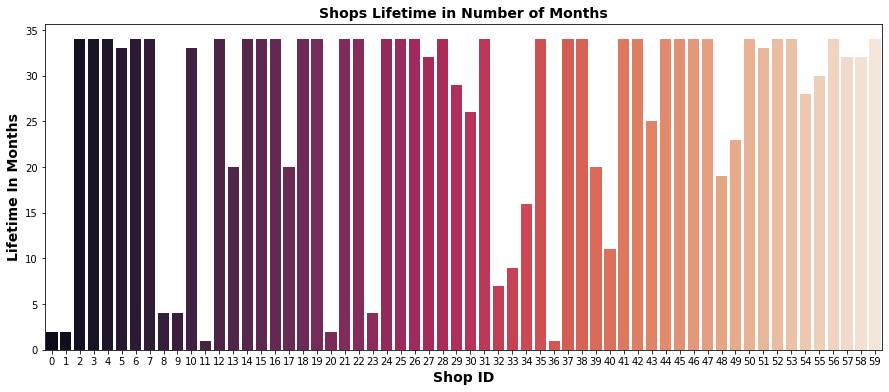

In [20]:
plt.figure(figsize=(15,6))
plt.title('Shops Lifetime in Number of Months',fontsize=14,fontweight='bold')
plt.xlabel('Shop ID',fontsize=14,fontweight='bold')
plt.ylabel('Lifetime In Months',fontsize=14,fontweight='bold')
sns.barplot(list(shop_lifetime.keys()),list(shop_lifetime.values()), palette='rocket')
plt.show()

As we can see, there are some shops with missing values during the time period of observation. We should pay attention to that, specially when analyzing which items have missing records to fill them with a value and give each one a similar behavior of a time series. 

### Best-Selling Categories

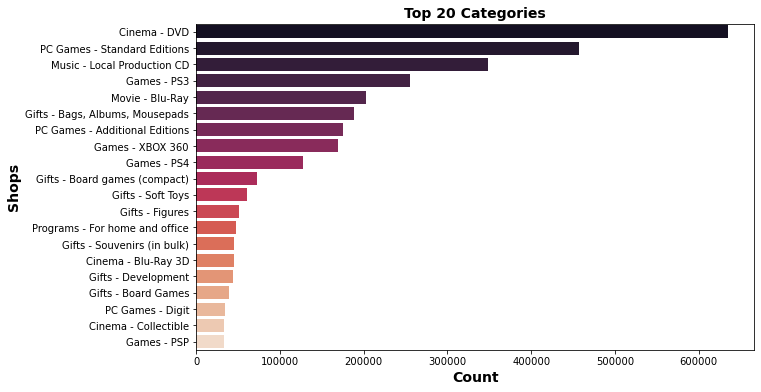

In [21]:
categories_df = train.groupby('item_category_name').item_cnt_day.sum()
cat_df = pd.DataFrame({'category': categories_df.index.tolist(), 'count': categories_df.values.tolist()})
cat_df = cat_df.sort_values(by='count',ascending=False).reset_index()
cat_df_translate = cat_df.copy()
cat_df_translate['category'] = cat_df.category.apply(lambda row: translateRussian(row))

plt.figure(figsize=(10,6))
plt.title('Top 20 Categories', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Shops', fontsize=14, fontweight='bold')
sns.barplot(cat_df['count'].tolist()[0:20],cat_df_translate.category.tolist()[0:20], palette='rocket')
plt.show()

So the top 5 best selling categories are related to cinema, videogames and music.

### Best-Selling Products

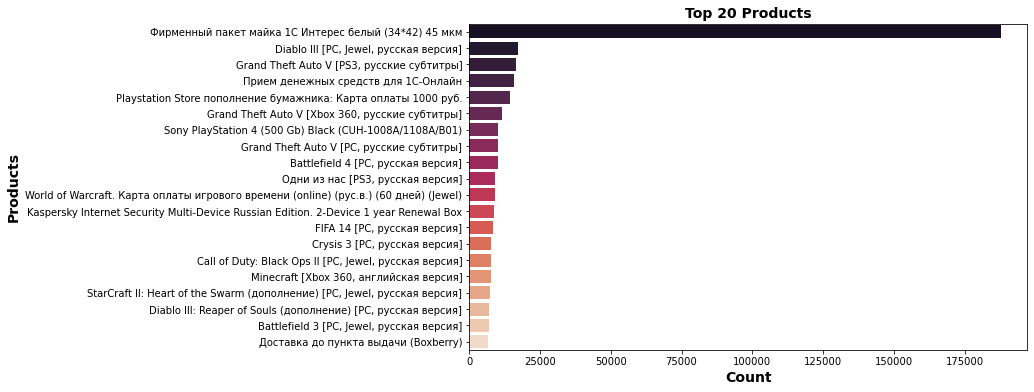

In [22]:
best_products = train.groupby('item_name').item_cnt_day.sum()
best_products = pd.DataFrame({"product":best_products.index.tolist(), "count":best_products.values.tolist()})
best_products = best_products.sort_values(by='count',ascending=False).reset_index()
plt.figure(figsize=(10,6))
plt.title('Top 20 Products', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Products', fontsize=14, fontweight='bold')
sns.barplot(best_products['count'].tolist()[0:20],best_products['product'].tolist()[0:20],palette='rocket')
plt.show()

Almost all of the best selling products listed are related to videogames. 

### Average Price vs Units Sold

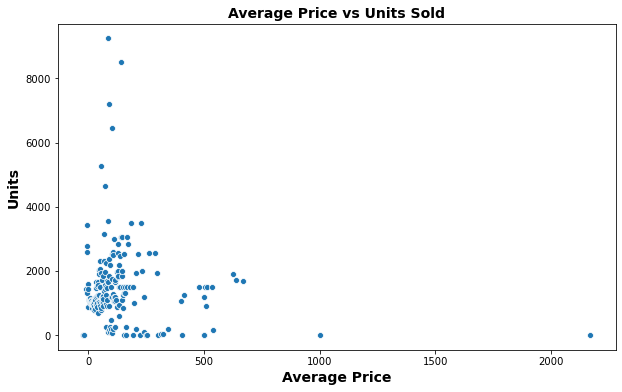

In [23]:
avg_price = train.groupby(['item_cnt_day']).item_price.mean()
plt.figure(figsize=(10,6))
plt.title('Average Price vs Units Sold', fontsize=14, fontweight='bold')
plt.xlabel('Average Price', fontsize=14, fontweight='bold')
plt.ylabel('Units', fontsize=14, fontweight='bold')
sns.scatterplot(avg_price.index.tolist(),avg_price.values.tolist())

We can notice some clustering <4000 units and <500 average price, but we can see that cheaper products have a lot of units sold. As the average price increses, the number of units sold decrease. 

<a id="section-seven"></a>
# 7. Data Cleaning 

Let's check for values below zero in the item_cnt_day column:

In [24]:
(train.item_cnt_day < 0).sum()

7356

Let's fill them with the median.

In [25]:
train.loc[train.item_cnt_day < 0, 'item_cnt_day'] = train.item_cnt_day.median() 

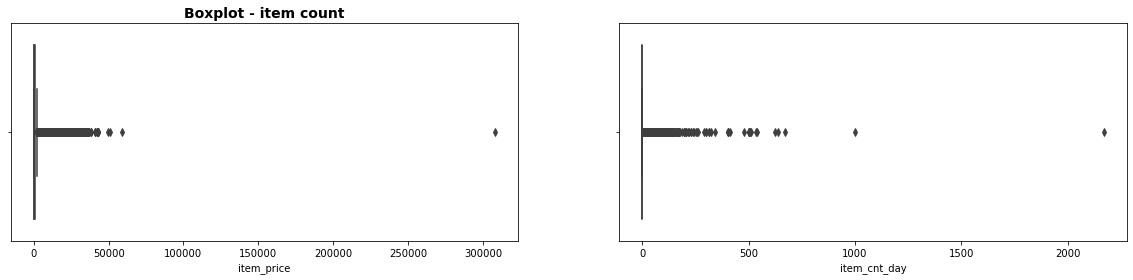

In [26]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, sharex = False, figsize = (20,4))
axes[0].set_title('Boxplot - item price', fontsize=14, weight='bold')
sns.boxplot(train.item_price, ax=axes[0])
axes[0].set_title('Boxplot - item count', fontsize=14, weight='bold')
sns.boxplot(train.item_cnt_day, ax=axes[1])

In [27]:
print((train.item_cnt_day > 10).sum()/train.shape[0]*100, "% of the dataset has item_cnt_day higher than 10")
print((train.item_price > 20000).sum()/train.shape[0]*100, "% of the dataset has item_cnt_day higher than 20000")

0.3445681300366606 % of the dataset has item_cnt_day higher than 10
0.2309723694917552 % of the dataset has item_cnt_day higher than 20000


From these plots, we can notice a lot of outliers. By the prints, we can consider item_cnt_day higher than 10 and item_price higher than 20000 outliers and hence remove them.

In [28]:
print('Number of examples before removal:', train.shape)
train = train[(train['item_cnt_day'] <= 10) & (train['item_price'] < 20000)]
print('Shape after removal:',train.shape)

Number of examples before removal: (2935849, 13)
Shape after removal: (2918980, 13)


In [29]:
((train.item_cnt_day > 10) | (train.item_price > 20000)).sum()

0

### Data Leakage

We must assure that the labels on the test set are the same that the ones seen on the training. Let's find out if this happens.

In [30]:
print('number of unique train.shop_id = ', len(train.shop_id.unique()))
print('number of unique test.shop_id = ', len(test.shop_id.unique()))
print('Train set shape before cleaning = ', train.shape[0])
train = train[train['shop_id'].isin(test.shop_id.unique())]
train = train[train['item_id'].isin(test.item_id.unique())]
print('Train set shape after cleaning = ', train.shape[0])


number of unique train.shop_id =  60
number of unique test.shop_id =  42
Train set shape before cleaning =  2918980
Train set shape after cleaning =  1214132


<a id="section-eight"></a>
# 8. Feature Engineering

Here the objective is to create/extract relevant data to give significant information to our model. These features will basically cover the following aspects:
* Firstly resample the data to a monthly observation (as we need to forecast sales to the end of November of 2015)
* Fill the missing records with zero
* Join test set to generate delay features for october 2015 predictions
* Lag Features
* Sliding Window Average


### Indexing by date_block_num

In [31]:
train_monthly = train.sort_values(by='date').groupby(['date_block_num','shop_id','item_category_id','item_id','month'],as_index=False).item_cnt_day.sum()
train_monthly.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)
train_monthly

,date_block_num,shop_id,item_category_id,item_id,month,item_cnt_month
0,0,2,2,5572,1,9.0
1,0,2,2,5643,1,2.0
2,0,2,5,5583,1,2.0
3,0,2,6,7893,1,3.0
4,0,2,6,7894,1,1.0
...,...,...,...,...,...,...
599008,33,59,75,5383,10,1.0
599009,33,59,79,17717,10,13.0
599010,33,59,83,22087,10,6.0
599011,33,59,83,22088,10,2.0


### Filling Missing Records

As we have seen before, there are some shops with limited lifetime. It can also be true to some products. The main goal here is to generate all the shop/product possibilities and fill with zero the ones that didn't exist in the dataset. 

In [32]:
date_block = []
shops = []
items=[]
cnt_day = []
for date in np.arange(0,34):
    for store in train_monthly.shop_id.unique():
        for product in train_monthly.item_id.unique():
            date_block.append(date)
            shops.append(store)
            items.append(product)
            
train_monthly = pd.merge(pd.DataFrame({'date_block_num':date_block,'shop_id':shops,'item_id':items}),
                                      train_monthly, on=['date_block_num','shop_id','item_id'], how='left')

train_monthly = train_monthly.fillna(0)
train_monthly.rename(columns={'item_cnt_day' : 'item_cnt_month'},inplace=True)
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,month,item_cnt_month
0,0,2,5572,2.0,1.0,9.0
1,0,2,5643,2.0,1.0,2.0
2,0,2,5583,5.0,1.0,2.0
3,0,2,7893,6.0,1.0,3.0
4,0,2,7894,6.0,1.0,1.0


### Mean Related Features

The idea here is to mean encode 'item_cnt_month' and 'item_price' by multiple combinations with other features, going from a more generic trend of the sales (taking into consideration only the month) and reaching more specific contexts (grouping by shop_id, item_id and others). 

In [33]:

def meanEncode(group,feature,new_feature,train_monthly):
    temp = train.sort_values(by='date').groupby(group,as_index=False)[feature].mean()
    train_monthly = pd.merge(train_monthly,temp,how='left',on=group)
    train_monthly.rename(columns={feature:new_feature},inplace=True)
    return train_monthly

new_features = ['date_item_mean_item_cnt','date_item_mean_item_price','date_shop_item_mean_item_cnt','date_shop_item_mean_item_price']
original_features = [['date_block_num','item_id'],['date_block_num','item_id','shop_id']]
base_features = ['item_cnt_day','item_price']

initial = 0
limit = 2
base_feature = 0
for group in range(len(original_features)):
    for feature in np.arange(initial,limit):
            train_monthly = meanEncode(original_features[group],base_features[base_feature],new_features[feature],train_monthly)
            base_feature+=1
    base_feature=0
    initial+=2
    limit+=2
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,month,item_cnt_month,date_item_mean_item_cnt,date_item_mean_item_price,date_shop_item_mean_item_cnt,date_shop_item_mean_item_price
0,0,2,5572,2.0,1.0,9.0,1.207143,1567.792857,1.285714,1532.857143
1,0,2,5643,2.0,1.0,2.0,1.183486,2376.532813,1.000000,2387.605000
2,0,2,5583,5.0,1.0,2.0,1.068966,648.382759,1.000000,594.150000
3,0,2,7893,6.0,1.0,3.0,1.179245,1846.718239,1.000000,1990.000000
4,0,2,7894,6.0,1.0,1.0,1.148649,1471.746622,1.000000,1490.000000


### Join Test Set

We are interested in predicting the 34th month sales. So we need to add the shop_ids and item_ids of our test set to ease the lag features generation. Here we concatenate the train set and the test set by the columns 'date_block_num', 'shop_id' and 'item_id'. After that, since we don't have the data for the 34th month, we fill the NaN values with zero. 

In [34]:
train_monthly
test['date_block_num'] = 34
train_monthly = pd.concat([train_monthly,test[['date_block_num','shop_id','item_id']]],ignore_index = True, sort=False)
train_monthly.drop_duplicates().reset_index(drop=True)
train_monthly.fillna(0,inplace=True)

### Generating Lag Features
The idea here is to have previous values (lags) for mean encoded features. We are applying lags of 1, 2, 3, 6 and 12 months. 

In [35]:
for feature in range(len(new_features)):
    for lag in [1,2,3,6,12]:
        original_ft = new_features[feature]+"_lag_%s"
        ft_name = (original_ft % lag)
        train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id','item_id'])[new_features[feature]].shift(lag)
        train_monthly[ft_name].fillna(0, inplace=True)
train_monthly.fillna(0,inplace=True)

In [36]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,month,item_cnt_month,date_item_mean_item_cnt,date_item_mean_item_price,date_shop_item_mean_item_cnt,date_shop_item_mean_item_price,...,date_shop_item_mean_item_cnt_lag_1,date_shop_item_mean_item_cnt_lag_2,date_shop_item_mean_item_cnt_lag_3,date_shop_item_mean_item_cnt_lag_6,date_shop_item_mean_item_cnt_lag_12,date_shop_item_mean_item_price_lag_1,date_shop_item_mean_item_price_lag_2,date_shop_item_mean_item_price_lag_3,date_shop_item_mean_item_price_lag_6,date_shop_item_mean_item_price_lag_12
0,0,2,5572,2.0,1.0,9.0,1.207143,1567.792857,1.285714,1532.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,5643,2.0,1.0,2.0,1.183486,2376.532813,1.000000,2387.605000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,5583,5.0,1.0,2.0,1.068966,648.382759,1.000000,594.150000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,7893,6.0,1.0,3.0,1.179245,1846.718239,1.000000,1990.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,7894,6.0,1.0,1.0,1.148649,1471.746622,1.000000,1490.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Statistical Features - Sliding Window

For these, we are going to group the data by shop_id and item_id and roll a window, counting with the current value, for the two previous months and compute mean, max, min and standard deviation for them. We are going to replace the NaN values with zero.

In [37]:
'''import time
start = time.time()
def getMin(row):
    return row.rolling(window=3,min_periods=1).min()

def getMax(row):
    return row.rolling(window=3,min_periods=1).max()

def getMean(row):
    return row.rolling(window=3,min_periods=1).mean()

def getStd(row):
    return row.rolling(window=3,min_periods=1).std()

train_monthly['item_cnt_min'] = train_monthly.groupby(['shop_id','item_id']).item_cnt_month.apply(lambda row: getMin(row))
train_monthly['item_cnt_max'] = train_monthly.groupby(['shop_id','item_id']).item_cnt_month.apply(lambda row: getMax(row))
train_monthly['item_cnt_mean'] = train_monthly.groupby(['shop_id','item_id']).item_cnt_month.apply(lambda row: getMean(row))
train_monthly['item_cnt_std'] = train_monthly.groupby(['shop_id','item_id']).item_cnt_month.apply(lambda row: getStd(row))'''

"import time\nstart = time.time()\ndef getMin(row):\n    return row.rolling(window=3,min_periods=1).min()\n\ndef getMax(row):\n    return row.rolling(window=3,min_periods=1).max()\n\ndef getMean(row):\n    return row.rolling(window=3,min_periods=1).mean()\n\ndef getStd(row):\n    return row.rolling(window=3,min_periods=1).std()\n\ntrain_monthly['item_cnt_min'] = train_monthly.groupby(['shop_id','item_id']).item_cnt_month.apply(lambda row: getMin(row))\ntrain_monthly['item_cnt_max'] = train_monthly.groupby(['shop_id','item_id']).item_cnt_month.apply(lambda row: getMax(row))\ntrain_monthly['item_cnt_mean'] = train_monthly.groupby(['shop_id','item_id']).item_cnt_month.apply(lambda row: getMean(row))\ntrain_monthly['item_cnt_std'] = train_monthly.groupby(['shop_id','item_id']).item_cnt_month.apply(lambda row: getStd(row))"

### Split the Data: Train, Validation and Test

In [38]:
X_train = train_monthly[(train_monthly['date_block_num'] < 33)]
y_train = X_train.item_cnt_month
X_train = X_train.drop(columns=['item_cnt_month'])

X_val = train_monthly[train_monthly['date_block_num'] == 33]
y_val = X_val['item_cnt_month']
X_val = X_val.drop(columns=['item_cnt_month'])

test  = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
test_set = train_monthly[train_monthly.date_block_num == 34].copy()
test_set.drop(columns=['item_cnt_month'],inplace=True,errors='ignore')
X_test = pd.merge(test[['shop_id','item_id']],test_set,how='left',on=['shop_id','item_id'])
X_test.fillna(0,inplace=True)
X_test = X_test[X_train.columns.tolist()]

X_train

del train
del test 

<a id="section-nine"></a>
# 9. Model Training

Due to time limitations, few hyperparameter variations were tested. Some of them were inspired by other Kaggle user approaches. XGB was chosen due to its robustness at dealing with these kind of tabular problems. 

In [39]:
from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 5)

[01:07:41] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.33567	validation_1-rmse:1.17648
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.12374	validation_1-rmse:0.96762
[2]	validation_0-rmse:1.00308	validation_1-rmse:0.88177
[3]	validation_0-rmse:0.93314	validation_1-rmse:0.83820
[4]	validation_0-rmse:0.89246	validation_1-rmse:0.80623
[5]	validation_0-rmse:0.85936	validation_1-rmse:0.79410
[6]	validation_0-rmse:0.83459	validation_1-rmse:0.79040
[7]	validation_0-rmse:0.81806	validation_1-rmse:0.78532
[8]	validation_0-rmse:0.80535	validation_1-rmse:0.77621
[9]	validation_0-rmse:0.79928	validation_1-rmse:0.77665
[10]	validation_0-rmse:0.79293	validation_1-rmse:0.77407
[11]	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [40]:
test_set.drop(columns=['item_cnt_month'],inplace=True,errors='ignore')
model.predict(test_set)

array([ 0.00692779, -0.01900482,  0.01172739, ..., -0.00010663,
       -0.00010663, -0.00010663], dtype=float32)

<a id="section-ten"></a>
# 10. Result
### Feature Importance

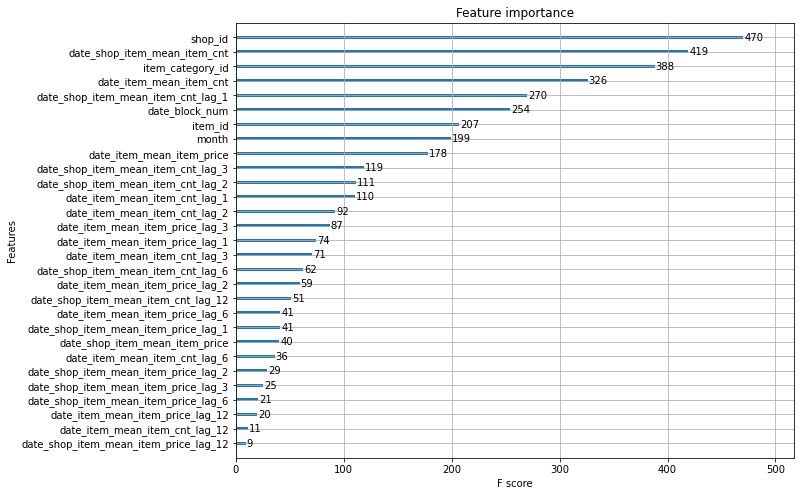

In [41]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,8))

As can be seen above, there are some features that not seem to help the model making decisions. These are mostly the lag features higher than 2 months. The shop_id seems to help the model the most, followed by the mean encoded features and its lags. These make sense since they reveal a closer behavior pattern to the target variable. 

<a id="section-eleven"></a>
# 11. Submission

In [42]:
Y_test = model.predict(X_test)

submission = pd.DataFrame({
    "ID": X_test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

<a id="section-twelve"></a>
# 12. Conclusion

We can say that the initial objective was reached. We have obtained some interesting insights about the data and the patterns related to the sales. Also, we have developed a model that can deal with different combinations of shop_ids and item_ids and forecast the sales with a reasonable RMSE. The results were really good on the train and validation sets, but not that much at the test set. Some observations could be made: 

* We have trained the model with all months <33, but due to our lag approach, it would make sense to use just examples with the date_block_num higher than twelve, since it is the highest delay applied to the features. 
* Due to some results that seemed suspicious of data leakage (too low RMSE) and memory shortage, our feature engineering process was really simple: mean encoding existing features and applying delay to them. Even so our results seemed pretty good for an initial approach. For further improvements, we plan to add the rolling windows with the already implemented functions (max, min, mean and std for a window=3). They seem too really help the model since they catch much closer and generic patterns for the sales behavior. 
* As we have seen on the feature importance plot, not all of the features seem to help the model. The ones closer to the target and related to the mean encoded features seem to help the model a lot, and indeed it makes sense, because these are highly correlated features to the target. Some experimentations could be made to evaluate how the model behaves. 
* Almost none hyperparameter tunning was done. This lead to convergence of the model and probably not the best model that we could reach. We intend to test different parameter and also test different models, such as LGBm, which is often used to deal with huge ammounts of data such as ours. 